In [1]:
#load libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Load Images

In [2]:
import os

directory = '29561_37705_bundle_archive/img_align_celeba/img_align_celeba/'

#get a list of images_names
imgs_list = os.listdir(directory)

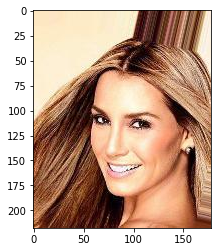

In [3]:
test_img = cv2.imread(directory+imgs_list[0])
test_img_copy = np.copy(test_img)
test_img_copy = cv2.cvtColor(test_img_copy, cv2.COLOR_BGR2RGB)

plt.imshow(test_img_copy)

In [4]:
def load_image(directory):
    #load in a image from a given directory return:ndarray of image
    img = cv2.imread(directory)
    img_copy = np.copy(img)
    img_copy = cv2.cvtColor(img_copy,cv2.COLOR_BGR2RGB)
    
    return img_copy     #return a (RGB) image in (height, width, channel)   

######################################
#remember to convert these into (c,h,w)----------------------------->DONE in load_faces func
######################################

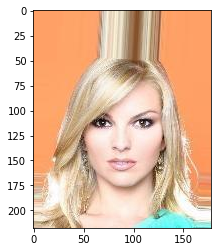

In [5]:
plt.imshow(load_image(directory+imgs_list[13155]))
# plt.imshow(cv2.resize(load_image(directory+imgs_list[13450]), (80,80)))

In [6]:
def extract_face(img_array, crop_size=(80,80)):
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
    
    gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    
    faces = face_cascade.detectMultiScale(gray)
    
    #if there are no faces detected return None
    if len(faces)==0:
        return None
    
    x1, y1, w, h = faces[0] 
    x2, y2 = x1+w, y1+h
    
    face_img = img_array[y1:y2, x1:x2]
    #resize image
    face_img = cv2.resize(face_img, crop_size)
    
    return face_img                 #return a crop_size cropped image of a face 

#############################
#if there are no faces detected this will return None datatype
#############################

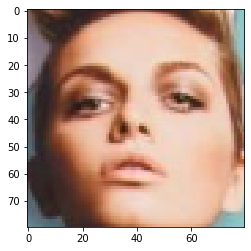

In [7]:
plt.imshow(extract_face(load_image(directory+imgs_list[4])))

In [8]:
extract_face(load_image(directory+imgs_list[4])).shape

(80, 80, 3)

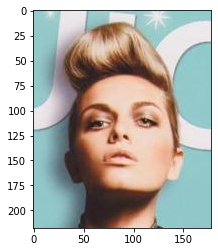

In [9]:
plt.imshow(load_image(directory+imgs_list[4]))

In [10]:
def load_faces(directory, imgs_list, n_faces):
    
    faces = list()
    
    for img_name in imgs_list:
        full_image = load_image(directory+img_name)
        face_img = extract_face(full_image)
        
        if face_img is None:
            continue
        
        #convert image to have shape (channel, height, weight) #this order is needed by PyTorch
        face_img = np.transpose(face_img, (2,0,1))
        faces.append(face_img)
        
        if len(faces) >= n_faces:
            break
            
    faces = np.asarray(faces)
            
    return faces  #return an array with cropped face images in shape (n_images, channel, height, width)

In [12]:
#create a test_faces array
test_faces = load_faces(directory, imgs_list, 256)

test_faces.shape

(256, 3, 80, 80)

In [14]:
#save created test_faces 
np.savez_compressed('img_align_celeba_test.npz', test_faces)

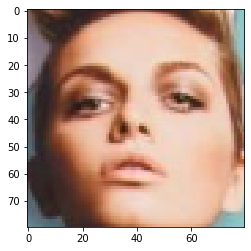

In [15]:
plt.imshow(np.transpose(test_faces[2], (1,2,0)))

## Create Faces Data

In [16]:
# all_faces = load_faces(directory, imgs_list, len(imgs_list))
# print('Loaded: ',all_faces.shape)

In [17]:
# #save created all_faces 
# np.savez_compressed('img_align_celeba.npz', all_faces)

## Load Faces Data

In [18]:
data = np.load('img_align_celeba_test.npz')

faces = data['arr_0']
print('Loaded: ',faces.shape)

Loaded:  (256, 3, 80, 80)


## Create DataLoader

In [19]:
#convert to floatTensor
faces = torch.from_numpy(faces).float()

In [23]:
#normalize pixel values to range(0,1)
faces_norm = faces/255

In [27]:
faces_norm.shape

torch.Size([256, 3, 80, 80])

In [28]:
dataset = torch.utils.data.TensorDataset(faces_norm)

In [33]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

## Visualize Data (Faces)

In [51]:
dataiter = iter(train_loader)

images = dataiter.next()[0]

In [52]:
images.shape

torch.Size([32, 3, 80, 80])

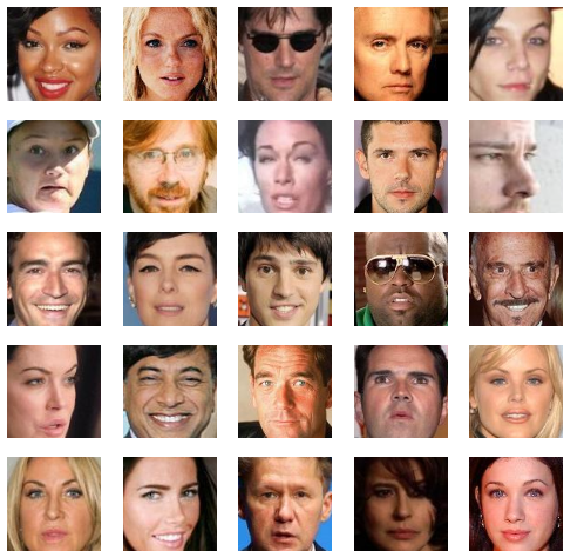

In [53]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(images[i], (1,2,0)))
plt.show()

## Define Discriminator

In [54]:
import torch.nn as nn
import torch.nn.functional as F

In [55]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        #input_size = (batch, 3, 80,80)
        
        self.conv1 = nn.Conv2d(3,128,3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(128,128,4, stride=2, padding=1)  
        self.conv3 = nn.Conv2d(128,128,4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128,128,4, stride=2, padding=1)
        self.conv5 = nn.Conv2d(128,128,4, stride=2, padding=1)  #out = (128,5,5)
        
        self.fc = nn.Linear(128*5*5,1)
        
        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self,x):
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        out = F.leaky_relu(self.conv5(out), 0.2)
        
        #flatten
        out = out.view(-1,128*5*5)
        
        out = self.dropout(out)
        out = self.fc(out)
        
        return out